In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
"""
CSSP via continious optimization as done in the paper (Moka et al., 2023).

The definitions of the terms are as follows:

X : The original data matrix (m,n) over which we apply CSSP to drop the columns. Here X is the small dataset comprising of
3 main columns, 2 correlated columns, 10 error columns and the y vector. 


delta : Fixed constant (parameter to control the penalized term in projection matrix)


t : The column (n,1), each element between 0 and 1 (continious). Getting a value less than threshold value (0.5 in paper)
indicates the column can be dropped. 


w : Non linear transform from t, (-log(1-t)) to make the optimization problem unconstrained.


lambda_ : Regularization parameter.


M : Monte Carlo size, used for approximation during gradient calculation, reducing computational complexity. In paper, M = 10. 


max_iter : Iterations done for gradient descent algorithm. 


Gradient descent algorithm is used to solve the optimization problem.

"""

'\nCSSP via continious optimization as done in the paper (Moka et al., 2023).\n\nThe definitions of the terms are as follows:\n\nX : The original data matrix (m,n) over which we apply CSSP to drop the columns. Here X is the small dataset comprising of\n3 main columns, 2 correlated columns, 10 error columns and the y vector. \n\n\ndelta : Fixed constant (parameter to control the penalized term in projection matrix)\n\n\nt : The column (n,1), each element between 0 and 1 (continious). Getting a value less than threshold value (0.5 in paper)\nindicates the column can be dropped. \n\n\nw : Non linear transform from t, (-log(1-t)) to make the optimization problem unconstrained.\n\n\nlambda_ : Regularization parameter.\n\n\nM : Monte Carlo size, used for approximation during gradient calculation, reducing computational complexity. In paper, M = 10. \n\n\nmax_iter : Iterations done for gradient descent algorithm. \n\n\nGradient descent algorithm is used to solve the optimization problem.\n\n'

### Define Projection Matrix for continious optimization

In [3]:
def Projection_matrix(X, t, delta):
    T0 = np.diag(t)
    convex1 = T0 @ X.T @ X @ T0
    I = np.eye(T0.shape[0])
    convex2 =  delta * (I - T0 @ T0)
    p_term = convex1 + convex2
    Pt = X @ T0 @ np.linalg.inv(p_term) @ T0 @ X.T
    return Pt

### Objective function or the Lagrangian

In [4]:
def objective(X, t, delta, lambda_):
    Pt = Projection_matrix(X, t, delta)
    trace_term = -np.trace(X.T @ Pt @ X)
    regularization_term = lambda_ * np.sum(t)
    return trace_term + regularization_term

### Computing the matrices required for gradient

In [5]:
def compute_matrices(X, t, delta):
    T0 = np.diag(t)
    K = X.T @ X
    Z = K - delta * np.eye(K.shape[0])
    Lt = T0 @ Z @ T0 + delta * np.eye(T0.shape[0])
    return K, Z, Lt, T0

def compute_phi(X, t, delta, lambda_, M):
    K, Z, Lt, T0 = compute_matrices(X, t, delta)
    phi_samples = []
    for _ in range(M):
        # Rademacher distribution
        z = np.random.choice([-1, 1], size=(K.shape[0],))  
        a = K @ z
        b = np.linalg.inv(Lt) * (t * a)  # Element-wise multiplication
        phi = (b * (Z @ (t * b))) - (a * b)  
        phi_samples.append(phi)
    phi_mean = np.mean(phi_samples, axis=0)
    return phi_mean

### Computing gradient using Monte Carlo size M approximation

In [6]:
def gradient(X, t, delta, lambda_, M):
    phi_mean = compute_phi(X, t, delta, lambda_, M)
    gradient = 2 * (1 / M) * phi_mean + lambda_ * np.eye(X.shape[1])
    return np.diag(gradient)

### Non linear transformation from t to w

In [7]:
def t_to_w(t):
    return np.sqrt(-np.log(1 - t))

def w_to_t(w):
    return 1 - np.exp(-(w**2))

### Gradient Descent Algorithm

In [8]:
def gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M):
    w = w_init
    
    for i in range(max_iter):
        grad = gradient(X, w, delta, lambda_, M)
        w -= learning_rate * grad
        t = w_to_t(w)
        
        if i % 100 == 0:
            print(f"Iteration {i}: t = {t}")
            print("\n")
            print(f"Iteration{i}: Objective Value={objective(X, w, delta, lambda_)}")
            print("\n")
        
    return w

### Optimal value of t for small dataset 

In [9]:
np.random.seed(0)
# Import data (small dataset)
df = pd.read_csv("D2XL1_small dataset.csv")
X = df.values 

n = X.shape[1]  
m = X.shape[0]  

# Initialize t and w
t_init = np.full(n, 0.5)  
w_init = np.sqrt(-np.log(1 - t_init))

# Constants
delta = 1
lambda_ = 1
learning_rate = 0.00001
max_iter = 1000
M = 10  # Monte Carlo sample size

# Optimized w and t using gradient descent
optimized_w = gradient_descent(X, w_init, delta, lambda_, learning_rate, max_iter, M)
print("\n")
print("Optimized w:", optimized_w)
print("\n")
print("Optimized t:", w_to_t(optimized_w))

Iteration 0: t = [0.50131835 0.53860757 0.50071369 0.5000079  0.49999466 0.52106905
 0.53339078 0.5392327  0.51625908 0.53826094 0.54264705 0.51284799
 0.51775172 0.50430196 0.50736865 0.50008672]


Iteration0: Objective Value=-379159.08047852607


Iteration 100: t = [1.         1.         1.         0.00215417 0.49657558 1.
 1.         1.         1.         1.         1.         1.
 1.         0.99998438 1.         1.        ]


Iteration100: Objective Value=-378608.50967590447


Iteration 200: t = [1.         1.         1.         0.43392864 0.49312729 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


Iteration200: Objective Value=-378677.681895916


Iteration 300: t = [1.         1.         1.         0.18517164 0.48952883 1.
 1.         0.84314583 1.         1.         1.         1.
 1.         0.54932889 1.         1.        ]


Iteration300: Objective Value=-378610.8844345368


Iteration 400: t = [1.         1.         1

### Optimal t

In [10]:
print("Optimized t:", w_to_t(optimized_w))

Optimized t: [1.         1.         0.99993779 0.00482157 0.46502663 1.
 1.         1.         1.         1.         1.         1.
 1.         0.55137634 1.         1.        ]


In [11]:
"""
Note that the t[i]'s with value less than 0.5 are the i'th columns of X to be dropped. 
In general we can  define a threshold for which t[i] < threshold implies the above. 
In the paper they have taken this threshold value as 0.5. 
So our final result of optimized t tells us to drop columns 4 and 5, or the two correlated columns. 

The values of lambda and delta depends on data. The paper mentions d = 1 as optimal, and do a grid search for value of lambda. 

"""


"\nNote that the t[i]'s with value less than 0.5 are the i'th columns of X to be dropped. \nIn general we can  define a threshold for which t[i] < threshold implies the above. \nIn the paper they have taken this threshold value as 0.5. \nSo our final result of optimized t tells us to drop columns 4 and 5, or the two correlated columns. \n\nThe values of lambda and delta depends on data. The paper mentions d = 1 as optimal, and do a grid search for value of lambda. \n\n"

### Hyper parameter tuning for lambda

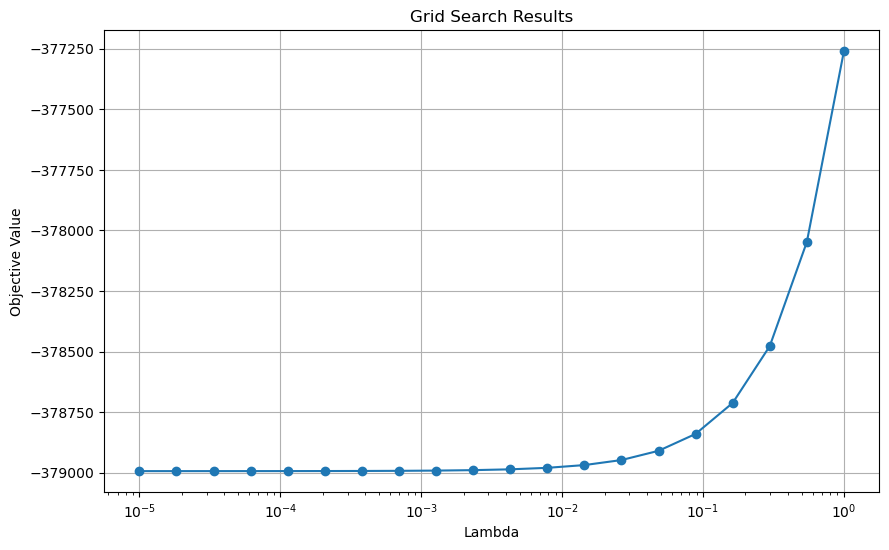

In [12]:
def grid_search(X, w_init, delta, lambdas, learning_rate, max_iter, M):
    results = []
    for lambda_ in lambdas:
        obj_value = objective(X, optimized_w, delta, lambda_)  
        results.append((lambda_, obj_value))
    return results

lambda_values = np.logspace(-5, 0, 20)

results = grid_search(X, w_init, delta, lambda_values, learning_rate, max_iter, M)

lambdas, objective_values = zip(*results)
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, objective_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Objective Value')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()

In [13]:
"""
Lambda = 1 seems optimal from the figure

"""

'\nLambda = 1 seems optimal from the figure\n\n'

In [14]:
"""
Note that the optimal values of lambda_ and delta are dependent on data and sensitive. High values of lambda_ will push the more 
w's to zero, delta meanwhile is taken as 1 like in the paper. 

The result is highly sensitive on M and learning rate of gradient descent, which also is dependent on data. Carrying parameter
tuning over all can be tedious and computationally expensive. 

So for each dataset, we need to figure out the values of lamda_, M and learning rate to get the optimal results. This can be too
tedious. A better way to get these values is needed. (to be done). 


"""

"\nNote that the optimal values of lambda_ and delta are dependent on data and sensitive. High values of lambda_ will push the more \nw's to zero, delta meanwhile is taken as 1 like in the paper. \n\nThe result is highly sensitive on M and learning rate of gradient descent, which also is dependent on data. Carrying parameter\ntuning over all can be tedious and computationally expensive. \n\nSo for each dataset, we need to figure out the values of lamda_, M and learning rate to get the optimal results. This can be too\ntedious. A better way to get these values is needed. (to be done). \n\n\n"